In [1]:
import os
import sys
import glob
import time
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import OrderedDict
from sklearn.neighbors import KDTree
from rasterio.windows import Window

sys.setrecursionlimit(10000)

In [2]:
SRC_PATH_PATTERN = '../data/interim/test/*/*.tif'
DST_CSV_PATH = '../data/processed/test_mosaic.csv'

### Helper functions

In [3]:
def read_image(path):
    """Read raster image from specified path (only 3 channles)"""
    with rasterio.open(path) as src:
        return src.read()[:3].transpose(1, 2, 0)
    
def read_borders(path):
    """Read 1-pixel borders from images (flattten to 1D array), 
    retruns Dict[str, np.ndarray]
    """
    with rasterio.open(path) as src:
        left = src.read(window=Window(0, 0, 1, 1024))[:3]
        right = src.read(window=Window(1023, 0, 1, 1024))[:3]
        top = src.read(window=Window(0, 0, 1024, 1))[:3]
        bottom = src.read(window=Window(0, 1023, 1024, 1))[:3]
    return dict(
        left=left.flatten(), 
        right=right.flatten(), 
        top=top.flatten(), 
        bottom=bottom.flatten(),
    )

def read_descriptors(paths):
    """Read image descriptors (borders)"""
    descriptors = OrderedDict()
    
    with tqdm(paths) as p_paths:
        for path in p_paths:
            id = os.path.basename(path)
            descriptor = read_borders(path)
            descriptors[id] = descriptor
    return descriptors

def get_neighbours(x1, x2, threshold=0.45):
    """Extract two nearest neigbours for each side of image, 
    if [distance to first]/[distance to second] < threshold assume that we find matching image"""
    x2_kd = KDTree(x2)
    distances, keys = x2_kd.query(x1, k=2)
    distances_rel = (distances[:, 0] + 0.0001) / (distances[:, 1] + 0.0001)
    keys = keys[:, 0]
    keys[distances_rel > threshold] = -1
    return keys

def check_validity(x1, x2):
    """Check neighbours validity, check that left neighbour for image right image is the same 
    as right nighbour for left image"""
    x1 = x1.copy()
    x2 = x2.copy()
    
    for i, k1 in enumerate(x1):
        if k1 != -1:
            j = x2[k1]
            if j == -1:
                x1[i] = -1
                
    for i, k1 in enumerate(x2):
        if k1 != -1:
            j = x1[k1]
            if j == -1:
                x2[i] = -1
            
    return x1, x2

def make_cluster(cluster, nb, k, visited, pos):
    """Create clusters of images accoring to its nearest neighbours"""
    cluster[k] = pos
    visited.add(k)
    node = nb[k]
    for _pos, connection in node.items():
        if connection not in visited and connection != -1:
            x, y = pos
            if _pos == 'left':
                x = x - 1
            if _pos == 'right':
                x = x + 1
            if _pos == 'top':
                y = y - 1
            if _pos == 'bottom':
                y = y + 1
            make_cluster(cluster, nb, connection, visited, pos=(x, y))
    
def normalize_cluster(cluster):
    """Looking for min X and min Y position values in cluster
    and shift them to make cluster position started from (0, 0)"""
    xs = [c[0] for c in cluster.values()]
    ys = [c[1] for c in cluster.values()]

    min_x = min(xs)
    min_y = min(ys)
    
    cluster_ = {}
    for k, v in cluster.items():
        cluster_[k] = (v[0] - min_x, v[1] - min_y)
    return cluster_

def get_xy_max(cluster):
    """Looking for max X nd Y positions in cluster"""
    xs = [c[0] for c in cluster.values()]
    ys = [c[1] for c in cluster.values()]
    return max(xs), max(ys)

def reverse_cluster(cluster):
    """Reverse clusters keys and values (encode name: poisiton -> position: name)"""
    return {v: k for k, v in cluster.items()}

### Creating mosaic

In [4]:
# reading descriptors
paths = glob.glob(SRC_PATH_PATTERN)
descriptors = read_descriptors(paths)

100%|██████████| 11481/11481 [11:52<00:00, 16.11it/s]


In [5]:
# extract descriptors for each side of image
left_arr = np.array([descriptors[k]["left"] for k in descriptors.keys()])[:, ::8]
right_arr = np.array([descriptors[k]["right"] for k in descriptors.keys()])[:, ::8]
top_arr = np.array([descriptors[k]["top"] for k in descriptors.keys()])[:, ::8]
bottom_arr = np.array([descriptors[k]["bottom"] for k in descriptors.keys()])[:, ::8]

In [6]:
# extarcting nearest negbours for each image according to its border descriptor
# heavy step, may take about 10 minutes
lr_keys = get_neighbours(left_arr, right_arr)
rl_keys = get_neighbours(right_arr, left_arr)
tb_keys = get_neighbours(top_arr, bottom_arr)
bt_keys = get_neighbours(bottom_arr, top_arr)

In [7]:
# check consistency of neighbours
lr_keys_, rl_keys_ = check_validity(lr_keys, rl_keys)
tb_keys_, bt_keys_ = check_validity(tb_keys, bt_keys)

In [8]:
# create neighbours dict
neighbours = {}
for i, k in enumerate(descriptors.keys()):
    neighbours[i] = dict(
        left=lr_keys_[i],
        right=rl_keys_[i],
        top=tb_keys_[i],
        bottom=bt_keys_[i],
    )

In [9]:
# create clusters of groupped images recursively going through neighbours
visited = set()
clusters = []

for i in range(len(paths)):
    if i not in visited:
        cluster = {}
        make_cluster(cluster, neighbours, i, visited, (0, 0))
        clusters.append(cluster)

### Visualization of mosaic (clusters)

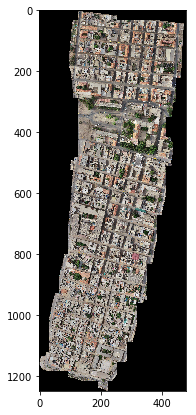

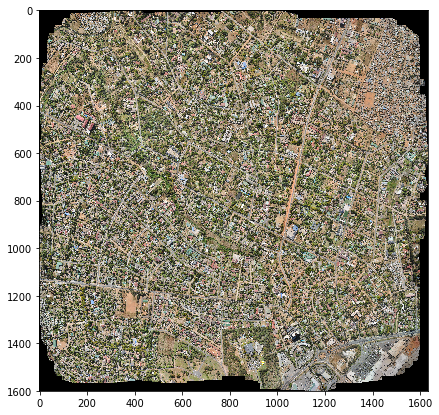

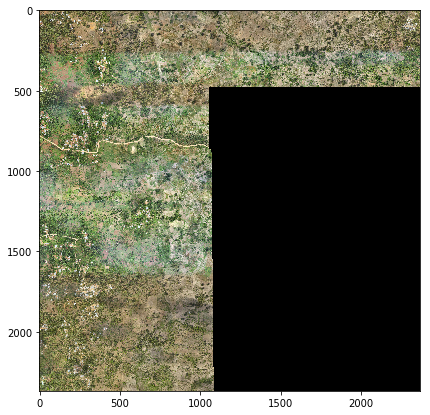

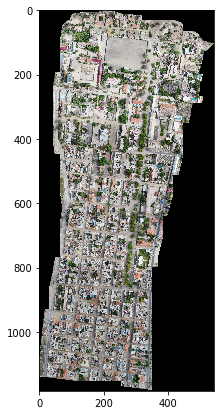

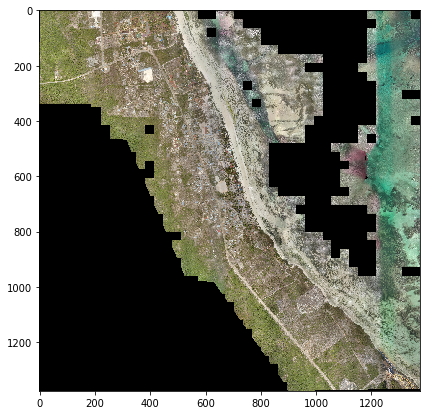

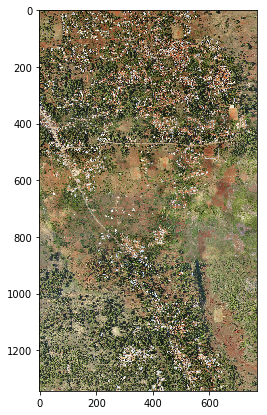

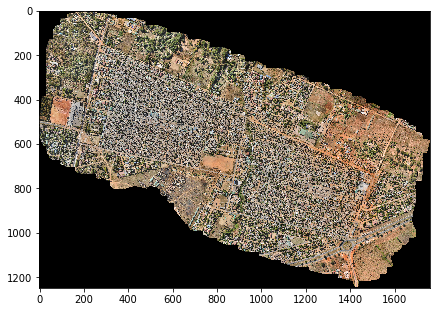

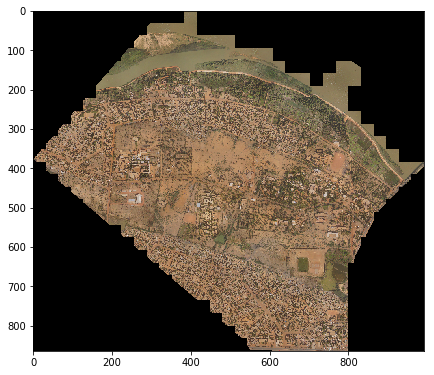

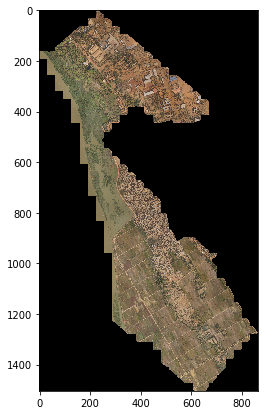

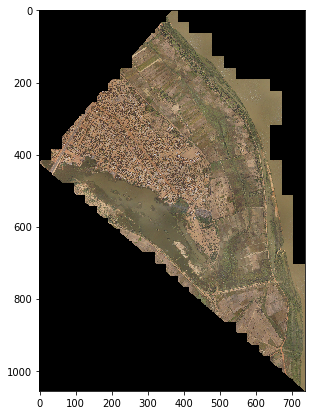

In [10]:
for cluster in clusters:
    if len(cluster.keys()) < 40:  # skip small clusters
        continue
    cluster = normalize_cluster(cluster)
    rev_cluster = reverse_cluster(cluster)

    x_min, y_min = 0, 0
    x_max, y_max = get_xy_max(cluster)

    sparsness = 32
    image = np.zeros(
        (
             1024 * (y_max + 1) // sparsness, 
             1024 * (x_max + 1) // sparsness, 
             3,
        ), dtype='uint8')


    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            try:
                k = rev_cluster[(x, y)]
                tile = read_image(paths[k])[::sparsness, ::sparsness]
                h, w = tile.shape[:2]
                image[h * y : h * (y + 1), w * x : w * (x + 1)] = tile
            except KeyError:
                pass

    plt.figure(figsize=(7, 7))
    plt.imshow(image)
    plt.show()

### Saving results

In [11]:
min_cluster_size = 5  # images
data = []

for i, cluster in enumerate(clusters):
    
    cluster_id = i if len(cluster.keys()) > min_cluster_size else -1
    cluster = normalize_cluster(cluster)  # make each mosaic (cluster of images) starting position (0, 0)

    for n, pos in cluster.items():
        data.append(dict(
            id=os.path.basename(paths[n]),
            cluster_id=cluster_id,
            x=pos[0],
            y=pos[1],
        ))

In [12]:
# Original tile size for test images is 1024 x 1024 pixels, however real spatial 
# resolution is deffernet for different scenes.
# This information present in train geotiff files, however missed in test images.
# So, for some test scenes I have estimated tile size according to public LB results
# to make test imagery resolution closer to 0.1 pixel per pixel
# as it is used during training NN models.

estimated_tile_size = {
    1: 320,
    2: 576,
    4: 320,
    5: 512,
    6: 704,
    7: 512,
}

df["tile_size"] = df.cluster_id.apply(lambda x: estimated_tile_size.get(x, 1024))  # 1024 is default value

In [13]:
df.to_csv(DST_CSV_PATH, index=False)
df.sample(20)

,cluster_id,id,x,y,tile_size
10872,10,714845.tif,6,8,1024
429,2,1648ba.tif,21,15,576
3311,3,d33f3d.tif,18,7,1024
3888,3,ba0831.tif,62,14,1024
5016,3,06398d.tif,9,49,1024
3331,3,08a65b.tif,38,7,1024
10694,10,1c54e5.tif,7,18,1024
1933,2,93cba6.tif,31,30,576
1530,2,4fcd97.tif,1,25,576
1297,2,a7f902.tif,49,19,576
